# NCI Weather Bench  - 10

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import dask.array as da
import glob
import matplotlib as mpl
import pprint 
from multiprocessing.pool import Pool
from multiprocessing import set_start_method
#set_start_method("spawn")
import os
from termcolor import colored

# Directories

In [2]:
NCI_dir = "/g/data/wb00/admin/testing/NCI_weatherbench/5.625deg"
wb_dir  = "/g/data/wb00/admin/testing/weatherbench/5.625deg"

def anomalies_a_year (file1, p_id):  
        
    try:
        ds_1 = xr.open_mfdataset(file1, chunks={'time':30}) 
        print (ds_1[p_id])
        #climatology = ds_1[p_id].groupby('time.month').mean()
        #anomaly =  ds_1[p_id].groupby('time.month') - climatology
        #mean = ds_1[p_id].mean( skipna=False, keep_attrs=False) 
        #mean = mean.compute().values.item()
        #std  = ds_1[p_id].std( skipna=False, keep_attrs=False) 
        #std  = std.compute().values.item()
        #print ( str(y) + ", ", end="", flush = True)
        #climatology = ds_1[p_id].mean(axis=( 2, 3))
        #climatology = climatology.compute().values.item()
        
        if len(ds_1[p_id].shape) == 3:  # surface level variables
            print ("add dim")
            ds_1[p_id] = ds_1[p_id].expand_dims("val", axis=1)
                
        mean = ds_1[p_id].mean(axis=( 0, 2, 3))
        mean = mean.compute().values.item()
        
        ds_1.close()
    except Exception as e:
        print(e)
        print(  " (Error), ", end = "", flush = True)
        #mean = 0.0  
        #std  = 0.0
    return mean
    #return  climatology


def yearly_anomalies_mp (NCI_dir, year1, year2, p_name, p_id):
    
    all_params = []
    for year in range (year1, year2+1):
        file1 = NCI_dir + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc'
        #all_params.append ( (year, file1, p_id) )
        all_params.append ( file1 )
        
        
    #pprint.pprint(all_params)    
    #with Pool() as pool:                  
        #year_list, mean_list, std_list  =  zip(* pool.starmap(anomalies_a_year, all_params) )  
        
    ano_list  = anomalies_a_year (all_params, p_id)
    #return list(ano_list)
    return  ano_list
 
##

def mean_a_year (y, file1, p_id):  
    if not os.path.exists(file1):
        print( str(y) + " ("+'\033[33m'+"Missing"+'\033[00m'+ "), ", end = "", flush = True) 
        return y, 0.0, 0.0
    try:
        ds_1 = xr.open_dataset(file1, chunks={'time':20}) 
        #mean = ds_1[p_id].mean(dim='time', skipna=False, keep_attrs=False) 
        mean = ds_1[p_id].mean( skipna=False, keep_attrs=False) 
        mean = mean.compute().values.item()
        std  = ds_1[p_id].std( skipna=False, keep_attrs=False) 
        std  = std.compute().values.item()
        print ( str(y) + ", ", end="", flush = True)
        ds_1.close()
    except Exception as e:
        print( str(y) + " (Error), ", end = "", flush = True)
        mean = 0.0  
        std  = 0.0
    return y, mean, std
    
def yearly_mean_mp (NCI_dir, year1, year2, p_name, p_id):
    
    all_params = []
    for year in range (year1, year2+1):
        file1 = NCI_dir + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc'
        all_params.append ( (year, file1, p_id) )
    #pprint.pprint(all_params)    
    with Pool() as pool:                  
        year_list, mean_list, std_list  = zip(* pool.starmap(mean_a_year , all_params) )    
    return list(year_list), list(mean_list) , list(std_list) 
               
        
def display_wb(file1, file2,  p_id, idx):  
    
    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(5, 2, wspace=0.1, hspace=0.8)
    plt.subplot(grid[0:2, 0:3])
    plt.bar(year_vals,  height = err_vals, align='edge', width = 0.3, color='gray',label='RMSE' )
    plt.margins(x=0)
    plt.xticks(year_vals)
    plt.xlabel("Years")
    plt.ylabel("RMSE")
    ax1 = plt.subplot(grid[2:, 0])
    plt.title(file1[:49] +'\n'+ file1[49:])
    im1 = plt.imshow(ds_1[p_id] [idx], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[2:, 1])
    plt.title(file2[:53] +'\n'+ file2[53:])
    im2 = plt.imshow(ds_2[p_id] [idx],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()          
        
        
def display_compare(year_vals, err_vals_1, err_vals_2, y_title):  
    
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(5, 2, wspace=0.1, hspace=0.8)
    plt.subplot(grid[0:2, 0:3])
    
    n = len(year_vals)
    idx = np.arange(n)
    width = 0.20
    
    plt.bar(idx        ,  height = err_vals_1, align='edge', width = width, color='blue'  , edgecolor = 'black', label='pangeo-wb'  )
    plt.bar(idx + width,  height = err_vals_2, align='edge', width = width, color='lightgreen' , edgecolor = 'black', label='NCI-wb'  )
    plt.margins(x=0)
    plt.xticks( idx + width/2, year_vals)
    plt.xlabel("Years")
    plt.xticks(rotation=45)
    plt.ylabel(y_title)
    plt.legend(loc='best')
    plt.show()
    
def display_cosntants(file1, file2, p_id):

    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.8)

    ax1 = plt.subplot(grid[0, 0])
    plt.title(file1[:49] +''+ file1[49:])
    im1 = plt.imshow(ds_1[p_id], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[0, 1])
    plt.title(file2[:53] +''+ file2[53:])
    im2 = plt.imshow(ds_2[p_id],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()     
    
    
def display_pressure_level(file1, file2, p_id, time, level):

    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.8)

    ax1 = plt.subplot(grid[0, 0])
    plt.title(file1[:49] +'\n'+ file1[49:])
    im1 = plt.imshow(ds_1[p_id][time][level], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[0, 1])
    plt.title(file2[:53] +'\n'+ file2[53:])
    im2 = plt.imshow(ds_2[p_id][time][level],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()    
    
def display_single_level(file1, file2, p_id, time):

    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.8)

    ax1 = plt.subplot(grid[0, 0])
    plt.title(file1[:49] +'\n'+ file1[49:])
    im1 = plt.imshow(ds_1[p_id][time], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[0, 1])
    plt.title(file2[:53] +'\n'+ file2[53:])
    im2 = plt.imshow(ds_2[p_id][time],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()            
    
        

In [3]:
!ls -hl {NCI_dir}

total 714K
drwxrws---+ 2 mah900 wb00 41K Apr 30 19:26 10m_u_component_of_wind
drwxrws---+ 2 mah900 wb00 41K May 31 20:10 10m_v_component_of_wind
drwxrws---+ 2 mah900 wb00 41K May 28 21:07 2m_temperature
-rw-rw----+ 1 mah900 wb00 67K May  1 20:23 constants.nc
drwxrws---+ 2 mah900 wb00 41K Apr 28 21:48 geopotential
drwxrws---+ 2 mah900 wb00 41K Apr 29 20:00 potential_vorticity
drwxrws---+ 2 mah900 wb00 41K Apr 28 11:57 relative_humidity
drwxrws---+ 2 mah900 wb00 41K Apr 30 00:18 specific_humidity
drwxrws---+ 2 mah900 wb00 41K May 26 20:58 temperature
drwxrws---+ 2 mah900 wb00 41K May 20 23:47 toa_incident_solar_radiation
drwxrws---+ 2 mah900 wb00 41K May  1 13:50 total_cloud_cover
drwxrws---+ 2 mah900 wb00 41K May 20 23:31 total_precipitation
drwxrws---+ 2 mah900 wb00 41K Apr 29 17:06 u_component_of_wind
drwxrws---+ 2 mah900 wb00 41K Apr 29 13:38 v_component_of_wind
drwxrws---+ 2 mah900 wb00 41K Apr 30 09:10 vorticity


# 10m_u_component_of_wind

1962 (Missing), 1964 (Missing), 1959 (Missing), 1960 (Missing), 1963 (Missing), 1961 (Missing), 1965 (Missing), 1968 (Missing), 1973 (Missing), 1976 (Missing), 1966 (Missing), 1967 (Missing), 1970 (Missing), 1974 (Missing), 1972 (Missing), 1975 (Missing), 1969 (Missing), 1971 (Missing), 1978 (Missing), 1977 (Missing), 2020 (Missing), 2022 (Missing), 2019 (Missing), 2021 (Missing), 1991, 2004, 2017, 1990, 2009, 1999, 2012, 1996, 1979, 2016, 2005, 1987, 2014, 1982, 2013, 1985, 1981, 1994, 2003, 2007, 1980, 1995, 2010, 1986, 1993, 2018, 2002, 2011, 1988, 2000, 2006, 1989, 1992, 1997, 1998, 1984, 2015, 1983, 2008, 2001, 
------
1969, 2005, 2004, 2011, 2008, 1974, 1973, 1959, 2001, 1986, 1998, 1978, 1964, 1963, 1975, 2009, 2007, 1992, 1999, 1989, 1977, 1962, 1995, 1991, 1961, 1983, 1984, 1985, 1988, 1993, 1982, 1994, 2006, 1980, 1960, 1972, 1987, 2013, 1979, 1970, 1968, 1965, 1996, 2002, 2014, 2000, 1981, 1976, 2015, 1967, 2003, 2016, 1966, 2012, 2018, 2019, 2017, 2022, 2021, 2020, 1971, 19

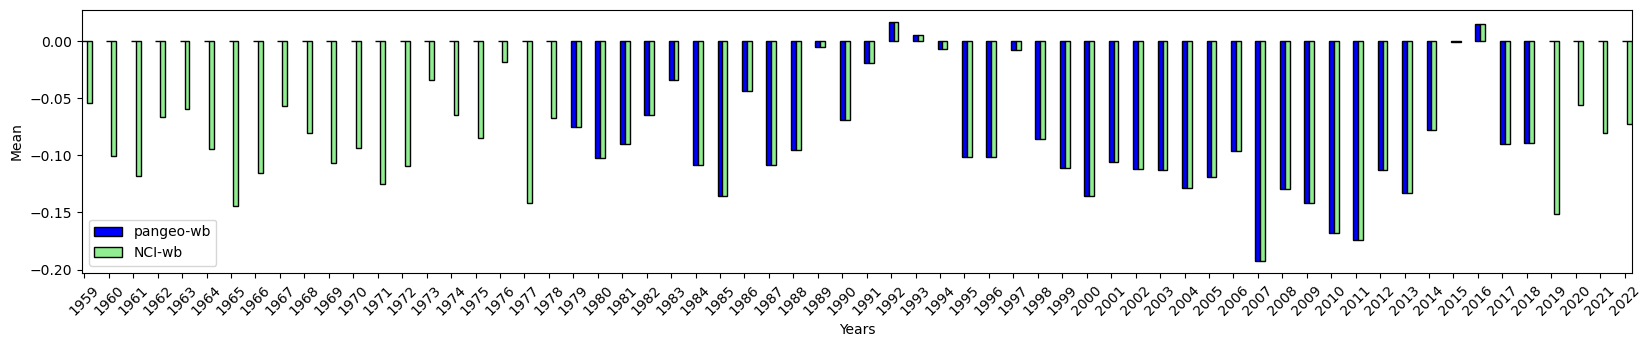

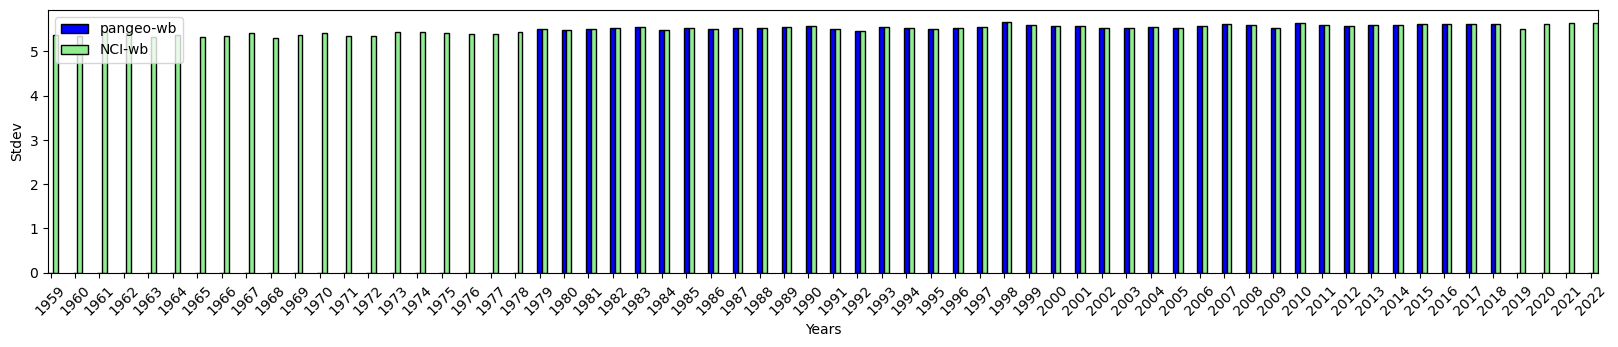

CPU times: user 2.11 s, sys: 685 ms, total: 2.79 s
Wall time: 23.8 s


In [4]:
%%time
 
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, '10m_u_component_of_wind', 'u10')  
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, '10m_u_component_of_wind', 'u10')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev") 
 

# 10m_v_component_of_wind

1959 (Missing), 1965 (Missing), 1961 (Missing), 1960 (Missing), 1962 (Missing), 1964 (Missing), 1967 (Missing), 1972 (Missing), 1963 (Missing), 1968 (Missing), 1973 (Missing), 1970 (Missing), 1969 (Missing), 1966 (Missing), 1976 (Missing), 1977 (Missing), 1974 (Missing), 1971 (Missing), 1978 (Missing), 1975 (Missing), 2022 (Missing), 2020 (Missing), 2021 (Missing), 2019 (Missing), 1982, 2007, 1987, 1988, 2002, 2003, 1989, 2012, 2005, 1990, 1995, 1983, 2010, 2006, 2000, 2004, 1999, 1998, 1991, 1992, 1984, 1979, 1981, 2009, 2013, 1986, 2017, 1994, 2008, 2015, 2001, 1997, 1985, 2014, 2016, 1996, 1980, 1993, 2011, 2018, 
------
2003, 1962, 1966, 1973, 1982, 1999, 2013, 2014, 2009, 2012, 1974, 2001, 1964, 1960, 1978, 1959, 2010, 2008, 1969, 1979, 1995, 1990, 2002, 2011, 2000, 1981, 1984, 1965, 1983, 1970, 1986, 1980, 1988, 1975, 1996, 1997, 2006, 1987, 1971, 1976, 1968, 2004, 1961, 2007, 1985, 1989, 1963, 1977, 1994, 1992, 1972, 2016, 2005, 1991, 1993, 2020, 2018, 2017, 2015, 1998, 2021, 20

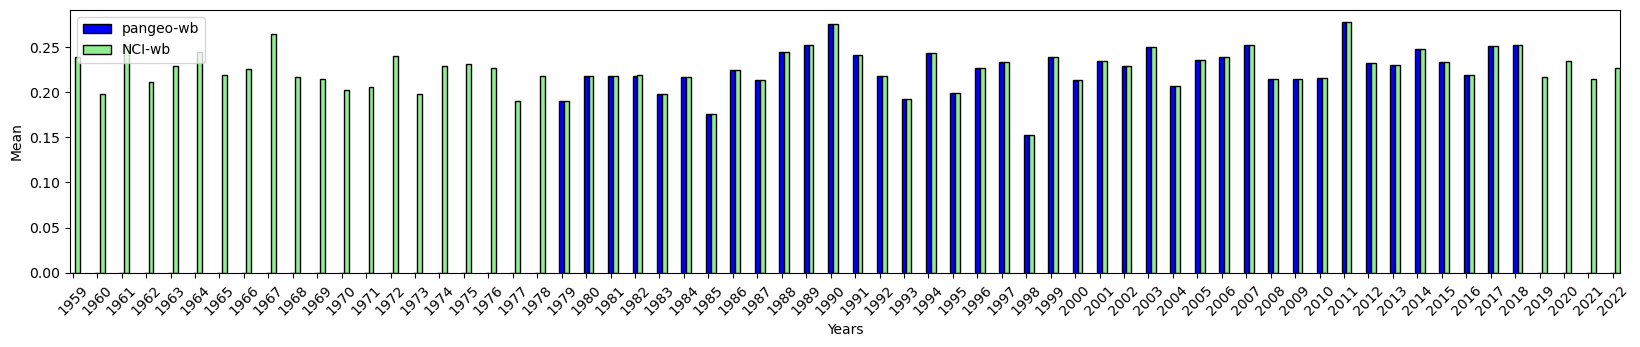

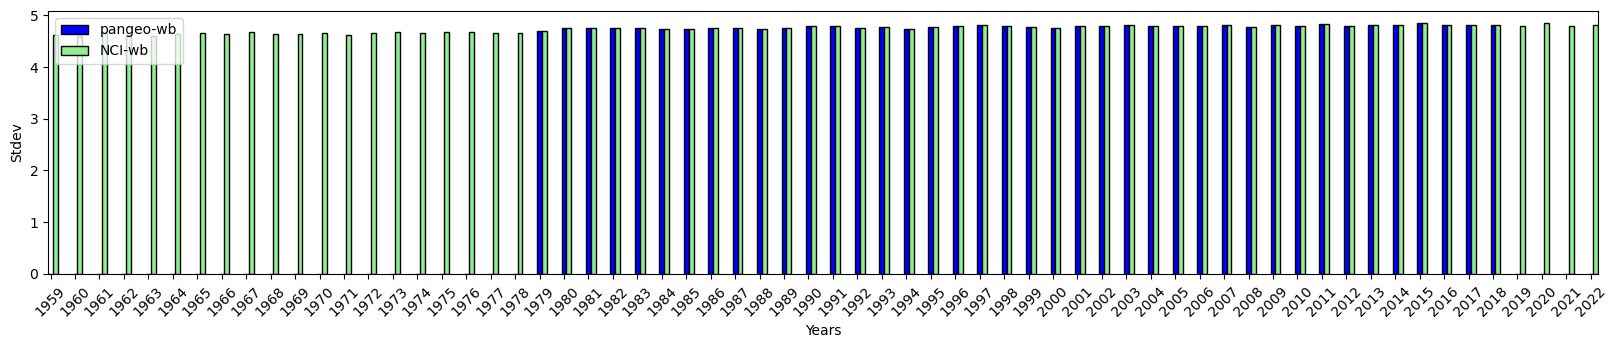

CPU times: user 1.49 s, sys: 637 ms, total: 2.12 s
Wall time: 16.6 s


In [5]:
%%time

year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, '10m_v_component_of_wind', 'v10') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, '10m_v_component_of_wind', 'v10')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev") 


# 2m_temperature


1960 (Missing), 1959 (Missing), 1964 (Missing), 1962 (Missing), 1961 (Missing), 1966 (Missing), 1963 (Missing), 1968 (Missing), 1965 (Missing), 1972 (Missing), 1967 (Missing), 1975 (Missing), 1973 (Missing), 1969 (Missing), 1971 (Missing), 1970 (Missing), 1974 (Missing), 1977 (Missing), 1978 (Missing), 1976 (Missing), 2019 (Missing), 2020 (Missing), 2021 (Missing), 2022 (Missing), 1995, 1980, 1996, 2010, 1997, 1979, 2005, 1985, 2013, 2018, 1990, 1981, 1991, 2017, 1992, 1998, 1993, 2004, 2012, 2014, 2006, 1987, 2001, 2011, 2009, 2003, 1989, 1986, 1994, 1999, 2008, 2015, 1988, 2000, 1983, 2007, 1984, 2016, 2002, 1982, 
------
1990, 1996, 2011, 1963, 1985, 1988, 1969, 2000, 1991, 1971, 2013, 1984, 2003, 1980, 1976, 2007, 1962, 1998, 1977, 1965, 1974, 2004, 1986, 1966, 1978, 1970, 1992, 2008, 1997, 2002, 1964, 1995, 2012, 2014, 2005, 1983, 1979, 1989, 1961, 2006, 1993, 1987, 1967, 2010, 1960, 1973, 1968, 1999, 2009, 2001, 1975, 2022, 2015, 2016, 2019, 1982, 2018, 2017, 1972, 1994, 1981, 19

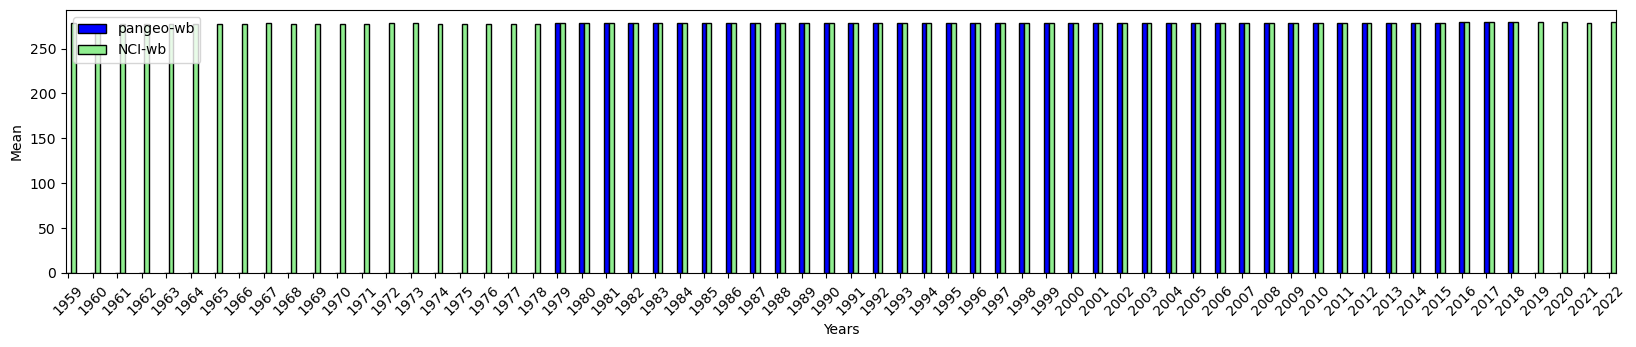

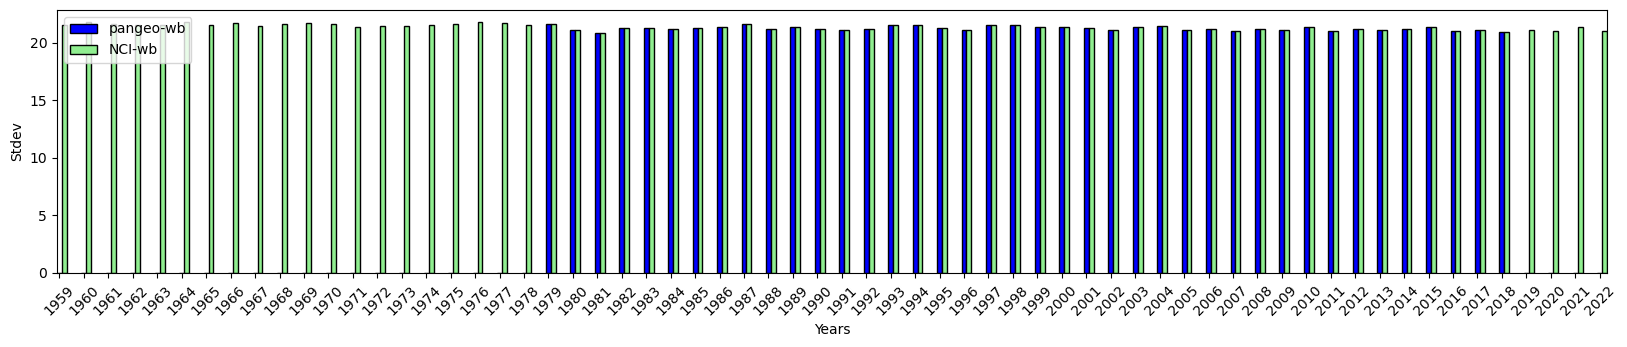

CPU times: user 1.61 s, sys: 651 ms, total: 2.26 s
Wall time: 12.2 s


In [6]:
%%time

year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022,  '2m_temperature', 't2m') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022,  '2m_temperature', 't2m')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev") 


# Constants


In [7]:
#file1 = wb_dir  + '/constants.nc'
#file2 = NCI_dir + '/constants.nc'

#display_cosntants(file1, file2, 'lsm')

In [8]:
#display_singles(file1, file2, 'orography')
#display_cosntants(file1, file2, 'orography')

In [9]:
#display_singles(file1, file2, 'slt')
#display_cosntants(file1, file2, 'slt')

In [10]:
#display_singles(file1, file2, 'lat2d')
#display_singles(file1, file2, 'lon2d')

# geopotential

1961 (Missing), 1960 (Missing), 1959 (Missing), 1965 (Missing), 1962 (Missing), 1963 (Missing), 1971 (Missing), 1966 (Missing), 1964 (Missing), 1967 (Missing), 1968 (Missing), 1969 (Missing), 1972 (Missing), 1970 (Missing), 1977 (Missing), 1973 (Missing), 1976 (Missing), 1974 (Missing), 1975 (Missing), 1978 (Missing), 2021 (Missing), 2022 (Missing), 2020 (Missing), 2019 (Missing), 1993, 1984, 2009, 1986, 1996, 1995, 1981, 2008, 1979, 2014, 2003, 2017, 1992, 2007, 2004, 1980, 2011, 1983, 2016, 2015, 2013, 2010, 1988, 1994, 1982, 1991, 1985, 2018, 2001, 1989, 1987, 2006, 2002, 2000, 1998, 2012, 1990, 1997, 2005, 1999, 
------
1988, 1986, 2008, 1977, 2002, 2011, 1967, 1960, 1965, 1987, 1982, 2006, 1991, 1984, 2014, 1996, 1993, 1969, 2010, 1994, 1968, 2009, 1959, 1980, 1964, 1999, 1998, 1992, 1979, 1997, 1961, 1972, 1966, 2000, 1973, 2005, 1963, 2003, 1962, 2001, 2012, 1990, 2013, 1981, 1995, 1978, 1970, 1983, 1985, 1976, 1971, 1974, 1975, 2017, 2016, 2004, 2021, 2007, 2022, 2019, 2015, 20

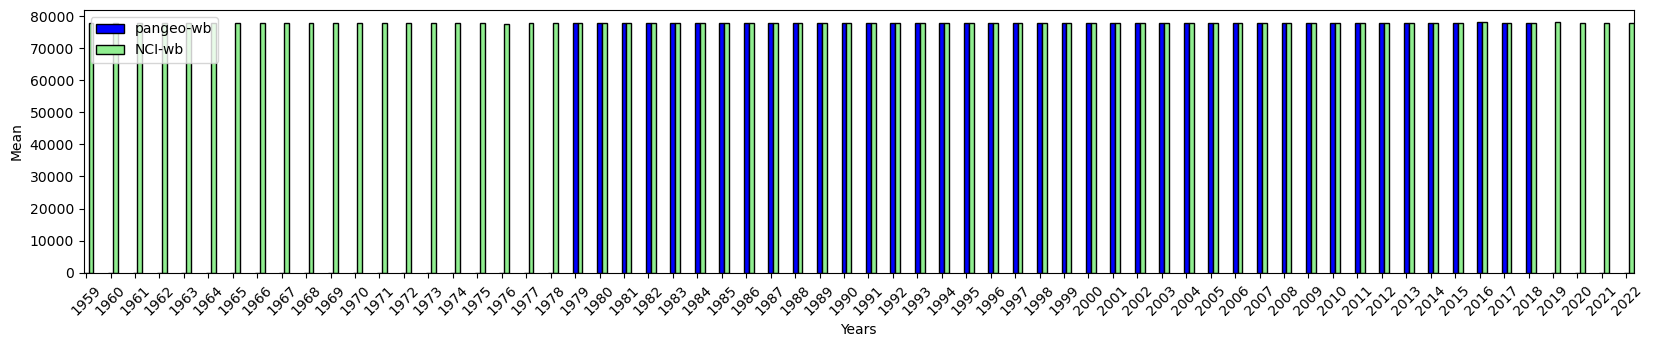

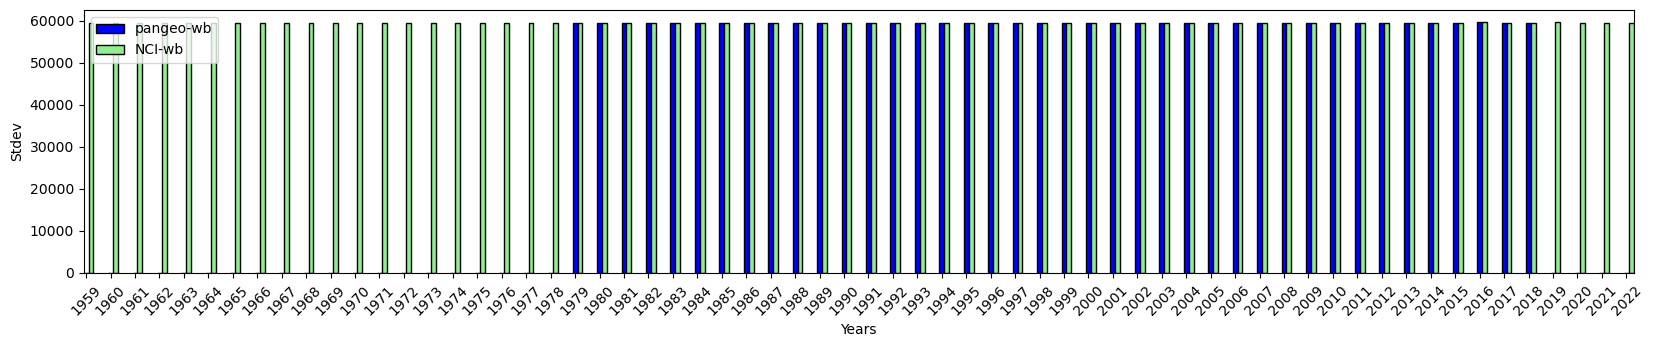

CPU times: user 1.94 s, sys: 591 ms, total: 2.53 s
Wall time: 1min 1s


In [11]:
%%time 
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022,  'geopotential', 'z') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022,  'geopotential', 'z')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev") 


# potential_vorticity

1961 (Missing), 1960 (Missing), 1959 (Missing), 1964 (Missing), 1965 (Missing), 1963 (Missing), 1962 (Missing), 1970 (Missing), 1969 (Missing), 1966 (Missing), 1972 (Missing), 1968 (Missing), 1975 (Missing), 1971 (Missing), 1988 (Missing), 1983 (Missing), 1967 (Missing), 1992 (Missing), 1974 (Missing), 1973 (Missing), 1979 (Missing), 1976 (Missing), 1978 (Missing), 1982 (Missing), 1980 (Missing), 1994 (Missing), 1981 (Missing), 1990 (Missing), 1987 (Missing), 1984 (Missing), 2002 (Missing), 1977 (Missing), 1986 (Missing), 1989 (Missing), 1996 (Missing), 1991 (Missing), 1993 (Missing), 2008 (Missing), 1998 (Missing), 1995 (Missing), 1999 (Missing), 2012 (Missing), 2000 (Missing), 2003 (Missing), 2019 (Missing), 2015 (Missing), 2021 (Missing), 2005 (Missing), 2007 (Missing), 2006 (Missing), 2001 (Missing), 2018 (Missing), 2017 (Missing), 1997 (Missing), 2010 (Missing), 2004 (Missing), 2011 (Missing), 2016 (Missing), 2020 (Missing), 2009 (Missing), 2022 (Missing), 2014 (Missing), 2013 (Mi

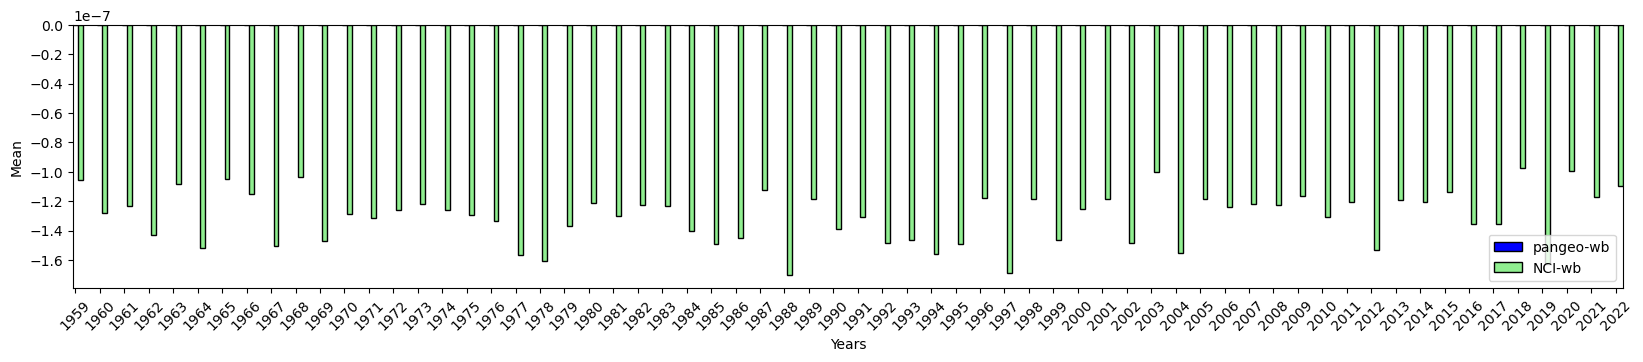

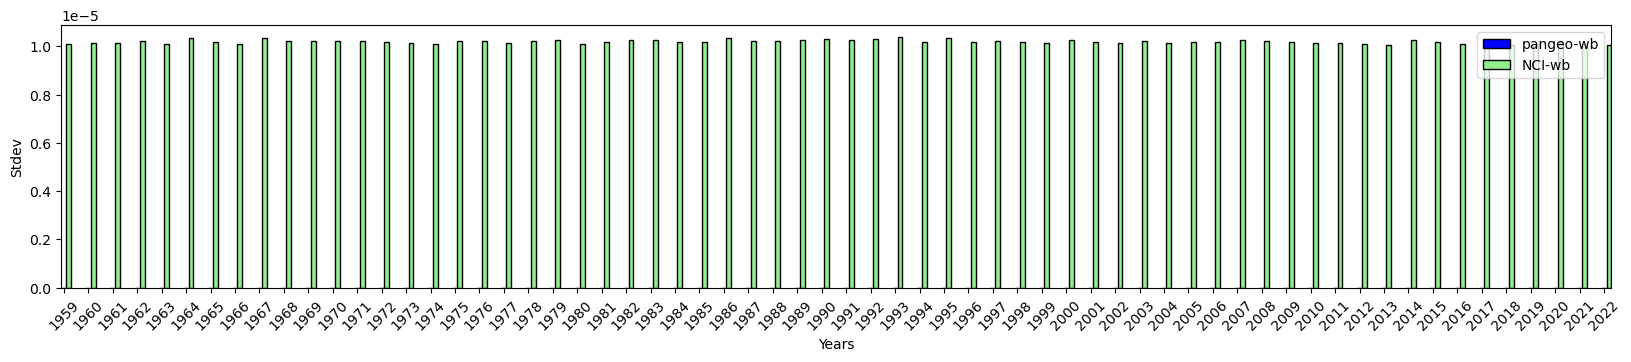

CPU times: user 1.81 s, sys: 1.06 s, total: 2.87 s
Wall time: 36.4 s


In [12]:
%%time 
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022,  'potential_vorticity', 'pv') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022,  'potential_vorticity', 'pv')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev") 

# relative_humidity

1960 (Missing), 1963 (Missing), 1961 (Missing), 1959 (Missing), 1962 (Missing), 1965 (Missing), 1970 (Missing), 1964 (Missing), 1969 (Missing), 1968 (Missing), 1975 (Missing), 1974 (Missing), 1971 (Missing), 1978 (Missing), 1972 (Missing), 1966 (Missing), 1973 (Missing), 1967 (Missing), 1976 (Missing), 1977 (Missing), 2019 (Missing), 2020 (Missing), 2021 (Missing), 2022 (Missing), 1993, 2004, 1985, 1987, 1979, 2008, 1980, 2002, 2007, 2014, 2000, 2017, 1995, 1990, 1981, 1991, 2016, 2003, 1999, 1992, 2009, 1986, 1982, 1997, 2006, 2011, 1996, 1984, 2018, 1988, 1983, 1989, 1994, 2001, 2015, 2005, 2010, 2012, 2013, 1998, 
------
1994, 1971, 1981, 2012, 2002, 1963, 1966, 1983, 1985, 1999, 1959, 1995, 2000, 1990, 1986, 2009, 1984, 1989, 1988, 2011, 1964, 1975, 2014, 1980, 1993, 1970, 2008, 1998, 2001, 1982, 1973, 1974, 1968, 1991, 2004, 1961, 1962, 1967, 1976, 1996, 1987, 1977, 1972, 1969, 1992, 2010, 2005, 1979, 1960, 2007, 2013, 1965, 2003, 2006, 1978, 2016, 2015, 1997, 2019, 2021, 2022, 20

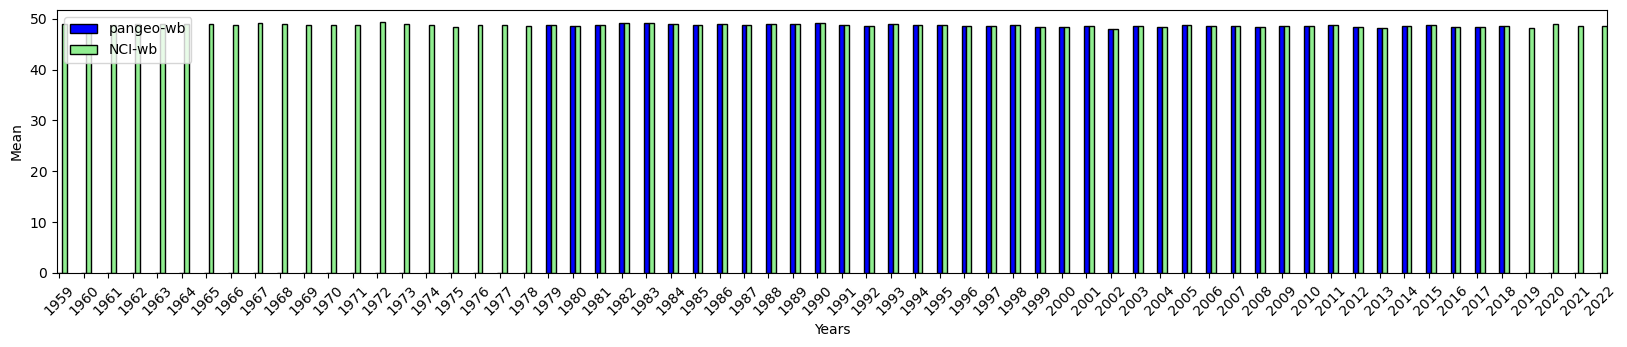

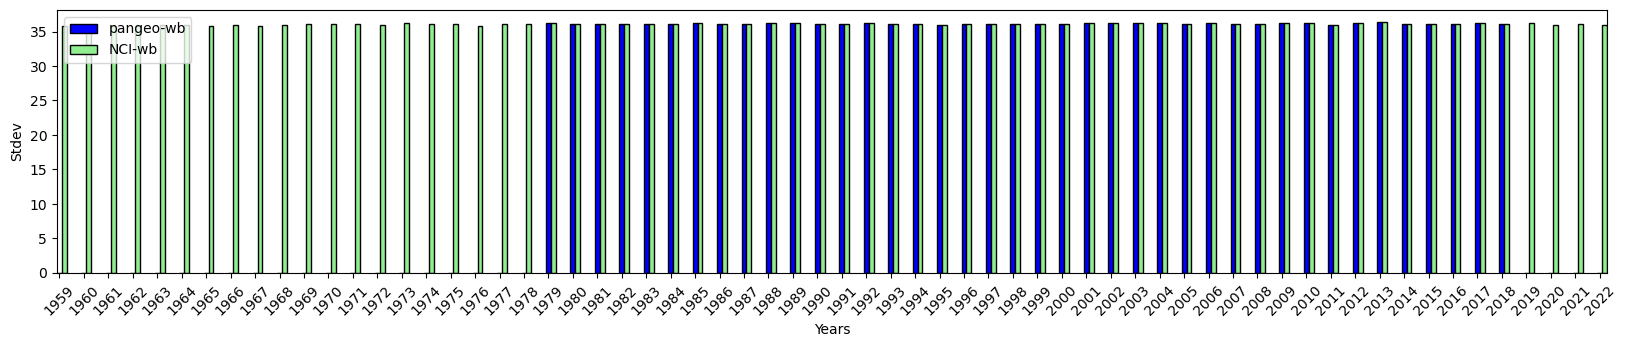

CPU times: user 1.66 s, sys: 637 ms, total: 2.3 s
Wall time: 1min 12s


In [13]:
%%time
 
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022,  'relative_humidity', 'r') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022,  'relative_humidity', 'r')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")  
 

# specific_humidity

1959 (Missing), 1960 (Missing), 1961 (Missing), 1967 (Missing), 1962 (Missing), 1963 (Missing), 1964 (Missing), 1968 (Missing), 1966 (Missing), 1971 (Missing), 1973 (Missing), 1969 (Missing), 1965 (Missing), 1977 (Missing), 1970 (Missing), 1975 (Missing), 1972 (Missing), 1974 (Missing), 1976 (Missing), 1978 (Missing), 2019 (Missing), 2020 (Missing), 2021 (Missing), 2022 (Missing), 1995, 2013, 2001, 1980, 2007, 1983, 2003, 2000, 1993, 2016, 2015, 1998, 2010, 2004, 1984, 2018, 1990, 2005, 1997, 1992, 1986, 1994, 2011, 2002, 1996, 1991, 1999, 1979, 1988, 2006, 2014, 2008, 2017, 1981, 2009, 1982, 1985, 1987, 2012, 1989, 
------
2002, 1970, 1961, 1974, 2012, 1964, 2001, 1968, 1965, 1966, 2000, 1995, 2013, 1985, 1979, 1983, 1959, 1993, 1994, 2010, 1962, 1971, 1963, 1978, 1981, 1973, 1997, 2007, 2011, 1992, 1991, 1969, 1988, 1967, 1999, 1975, 1989, 1987, 2008, 1990, 1984, 1996, 2006, 1986, 1960, 1972, 2009, 2015, 1977, 2019, 2004, 1976, 2018, 2017, 2022, 2021, 1998, 2016, 2020, 2014, 1980, 19

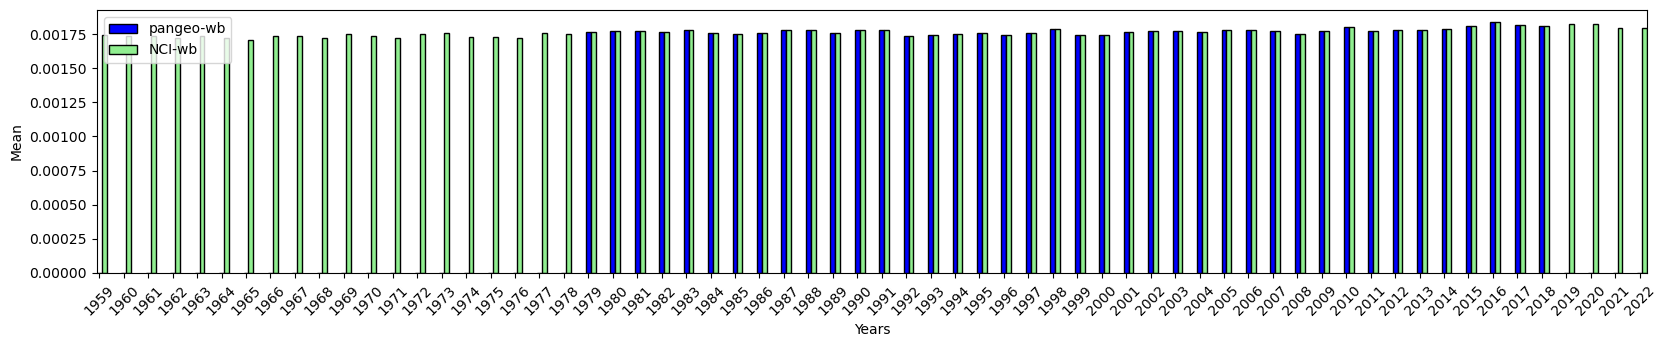

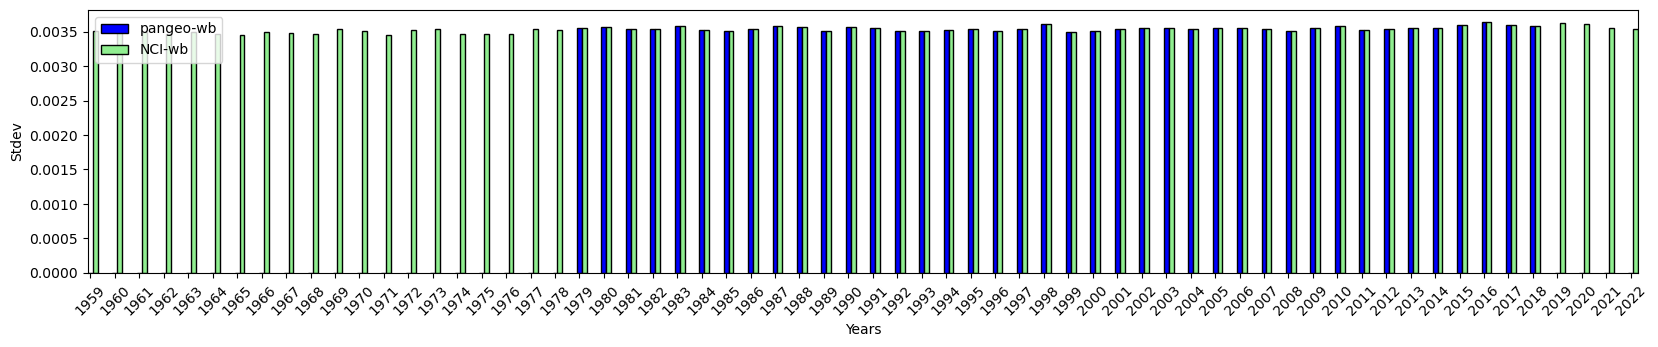

CPU times: user 1.81 s, sys: 682 ms, total: 2.49 s
Wall time: 1min 16s


In [14]:
%%time 
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'specific_humidity', 'q') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'specific_humidity', 'q')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")  


# temperature

1966 (Missing), 1965 (Missing), 1960 (Missing), 1959 (Missing), 1963 (Missing), 1964 (Missing), 1961 (Missing), 1967 (Missing), 1962 (Missing), 1973 (Missing), 1968 (Missing), 1970 (Missing), 1969 (Missing), 1972 (Missing), 1971 (Missing), 1976 (Missing), 1975 (Missing), 1974 (Missing), 1977 (Missing), 1978 (Missing), 2020 (Missing), 2019 (Missing), 2021 (Missing), 2022 (Missing), 1979, 2015, 1987, 2001, 1999, 1996, 1986, 2018, 2007, 1998, 2013, 2016, 1988, 1985, 2011, 1984, 2005, 1992, 2002, 1983, 1993, 2004, 2017, 1990, 2008, 1995, 1991, 2012, 2000, 1980, 1982, 2009, 1997, 2003, 1989, 1994, 1981, 2014, 2006, 2010, 
------
2013, 1962, 2004, 1966, 1990, 2002, 1996, 1987, 1965, 2011, 1982, 2010, 1964, 1995, 1978, 2003, 1972, 1988, 1973, 1989, 1970, 1971, 1998, 2008, 2005, 2014, 1994, 1999, 2012, 2007, 1969, 1961, 1992, 2001, 1985, 1980, 1974, 1984, 1981, 2000, 1977, 1991, 2006, 1975, 1976, 1960, 1993, 1986, 1983, 2017, 1997, 2019, 2020, 2009, 2021, 1967, 1963, 1968, 1979, 2015, 2016, 20

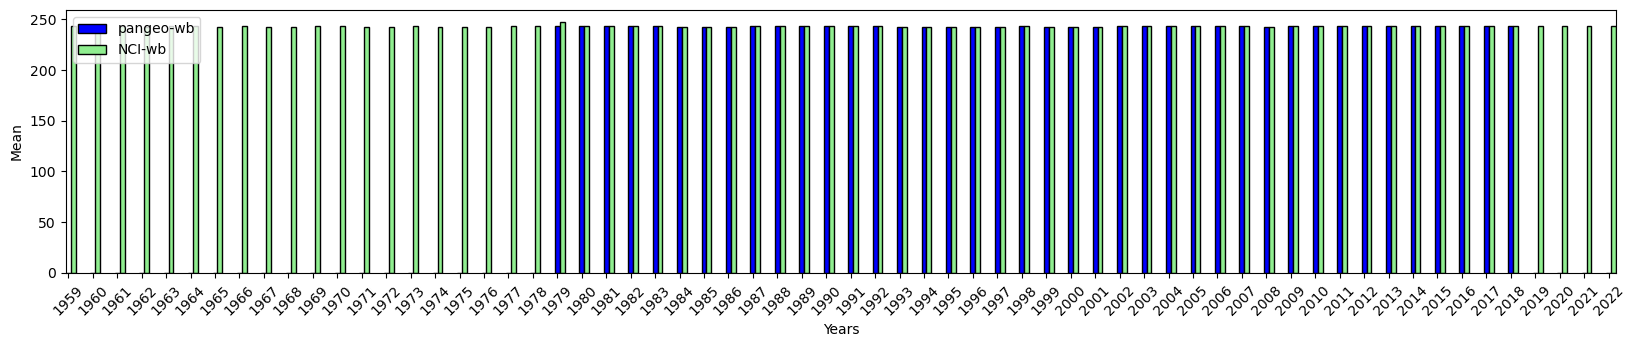

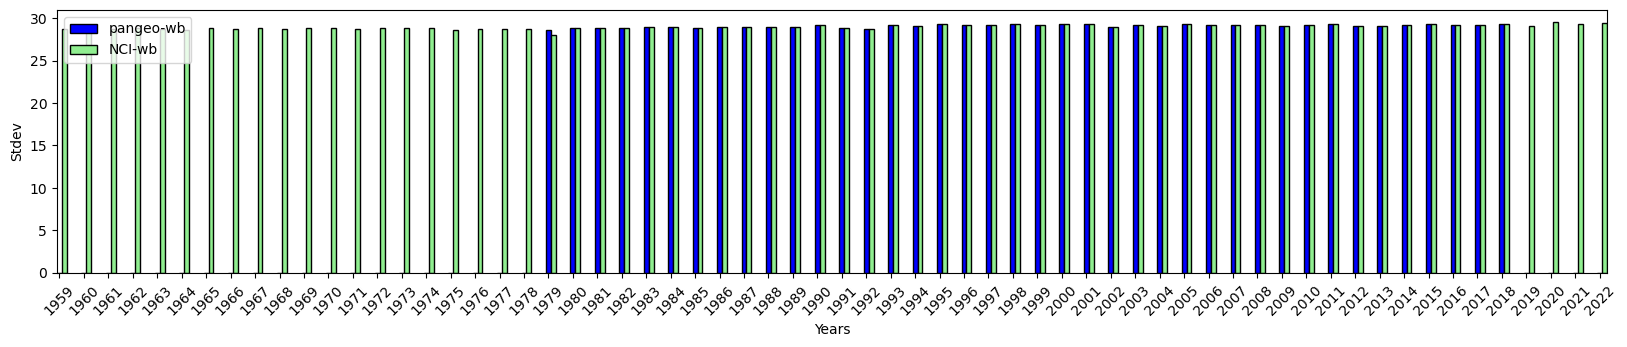

CPU times: user 1.58 s, sys: 641 ms, total: 2.22 s
Wall time: 58.6 s


In [15]:
%%time
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'temperature', 't') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'temperature', 't')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")   


# toa_incident_solar_radiation

1965 (Missing), 1968 (Missing), 1961 (Missing), 1962 (Missing), 1960 (Missing), 1959 (Missing), 1966 (Missing), 1964 (Missing), 1963 (Missing), 1967 (Missing), 1969 (Missing), 1972 (Missing), 1971 (Missing), 1970 (Missing), 1978 (Missing), 1977 (Missing), 1975 (Missing), 1973 (Missing), 1974 (Missing), 1976 (Missing), 2022 (Missing), 2020 (Missing), 2021 (Missing), 2019 (Missing), 2003, 2002, 1981, 1997, 2007, 1999, 2017, 2006, 1982, 1993, 1994, 2013, 1991, 2000, 1988, 2001, 1983, 1984, 1995, 1985, 1996, 1990, 1987, 1979, 1992, 2018, 1980, 2010, 2005, 2015, 2004, 2012, 1998, 2008, 1989, 1986, 2011, 2014, 2009, 2016, 
------
2009, 2006, 1994, 1964, 1971, 2013, 2005, 2014, 1988, 1963, 1989, 2001, 1987, 1984, 1973, 2002, 1986, 1980, 1981, 1979, 1990, 1970, 1978, 2012, 2003, 2007, 1996, 1998, 2008, 1965, 2004, 1982, 2010, 1995, 1966, 1999, 2011, 1977, 1975, 2000, 1960, 1972, 1959, 1993, 1992, 1974, 1968, 1976, 1991, 1969, 1997, 1983, 2022, 2019, 1967, 1961, 2017, 1962, 2018, 2016, 2015, 19

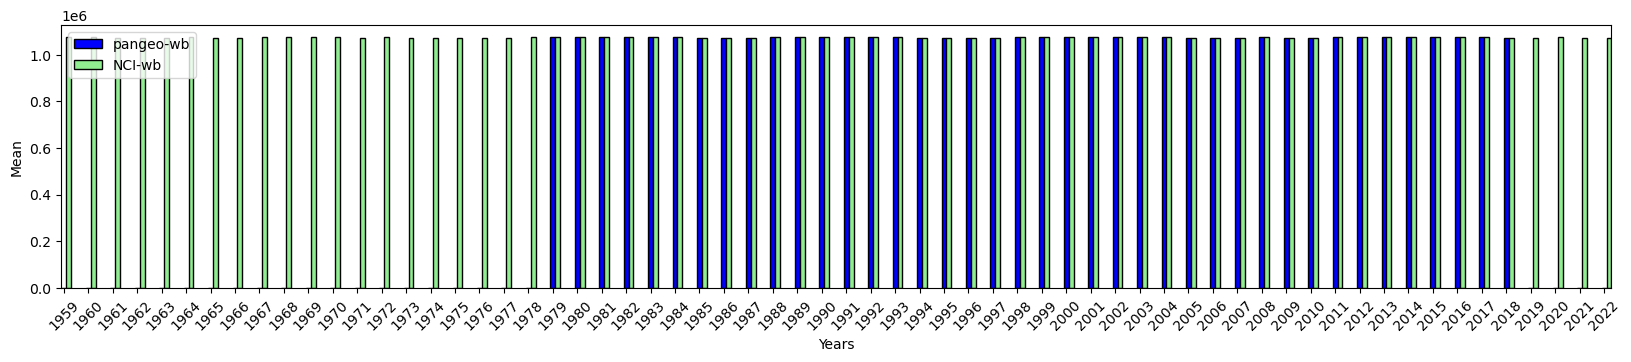

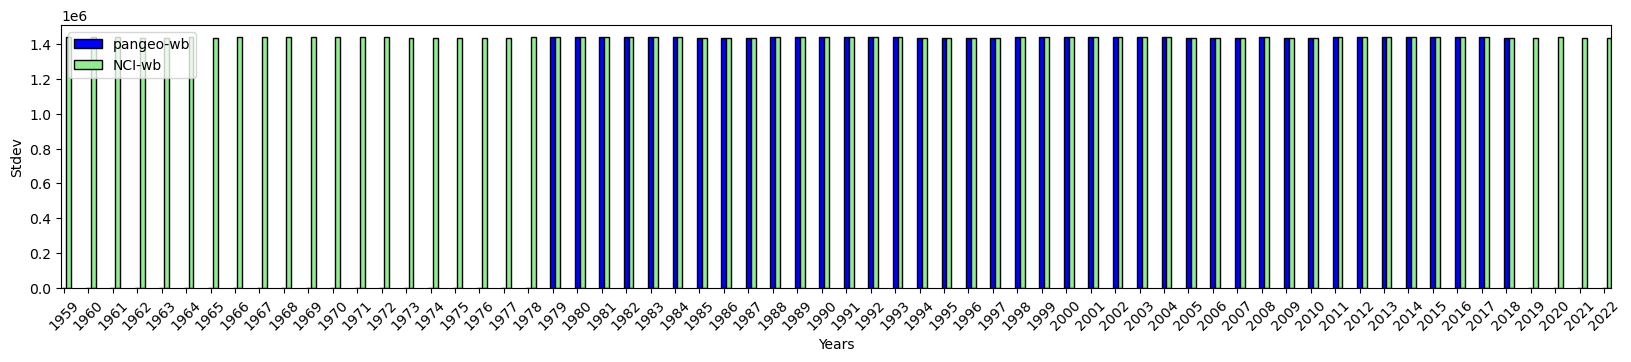

CPU times: user 1.94 s, sys: 614 ms, total: 2.55 s
Wall time: 17.1 s


In [16]:
%%time
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'toa_incident_solar_radiation', 'tisr') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'toa_incident_solar_radiation', 'tisr')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")   

# total_cloud_cover

1965 (Missing), 1960 (Missing), 1959 (Missing), 1963 (Missing), 1962 (Missing), 1961 (Missing), 1966 (Missing), 1964 (Missing), 1969 (Missing), 1967 (Missing), 1973 (Missing), 1972 (Missing), 1970 (Missing), 1979 (Missing), 1971 (Missing), 1984 (Missing), 1974 (Missing), 1980 (Missing), 1968 (Missing), 1976 (Missing), 1983 (Missing), 1978 (Missing), 1992 (Missing), 1991 (Missing), 1977 (Missing), 1994 (Missing), 1989 (Missing), 1981 (Missing), 1982 (Missing), 1998 (Missing), 1975 (Missing), 1987 (Missing), 1990 (Missing), 1988 (Missing), 1997 (Missing), 1986 (Missing), 2001 (Missing), 1996 (Missing), 1995 (Missing), 1993 (Missing), 2008 (Missing), 2004 (Missing), 2015 (Missing), 2003 (Missing), 2000 (Missing), 2007 (Missing), 2005 (Missing), 2013 (Missing), 1999 (Missing), 2002 (Missing), 2016 (Missing), 2017 (Missing), 2012 (Missing), 2020 (Missing), 2019 (Missing), 2006 (Missing), 2011 (Missing), 2022 (Missing), 2009 (Missing), 2018 (Missing), 2014 (Missing), 2021 (Missing), 2010 (Mi

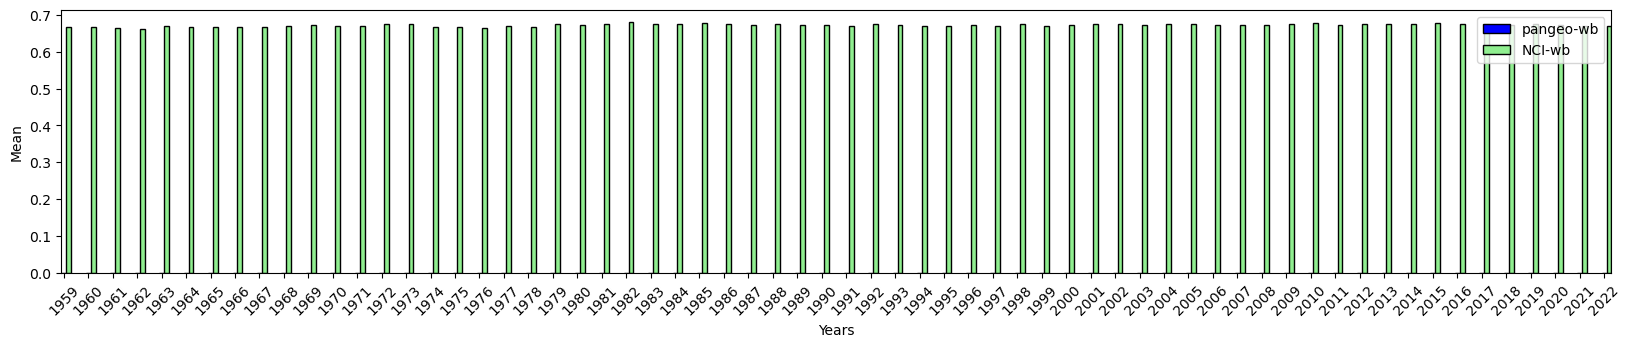

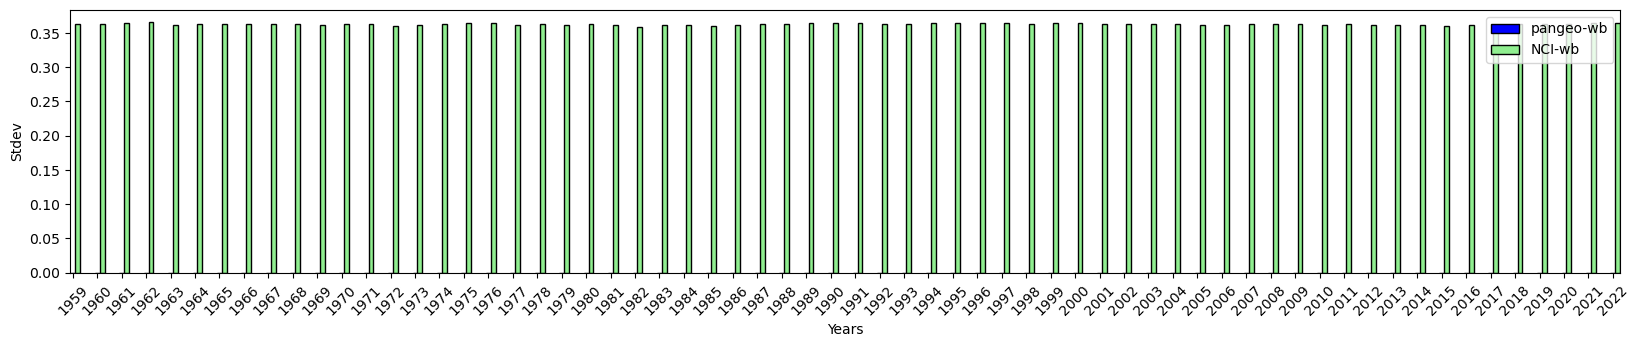

CPU times: user 1.5 s, sys: 614 ms, total: 2.12 s
Wall time: 10.4 s


In [17]:
%%time
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'total_cloud_cover', 'tcc') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'total_cloud_cover', 'tcc')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")  

# total_precipitation

1959 (Missing), 1964 (Missing), 1961 (Missing), 1962 (Missing), 1969 (Missing), 1960 (Missing), 1967 (Missing), 1963 (Missing), 1968 (Missing), 1966 (Missing), 1972 (Missing), 1965 (Missing), 1970 (Missing), 1971 (Missing), 1974 (Missing), 1975 (Missing), 1977 (Missing), 1973 (Missing), 1976 (Missing), 1978 (Missing), 2019 (Missing), 2021 (Missing), 2022 (Missing), 2020 (Missing), 2001, 2017, 2002, 1996, 1980, 2014, 2000, 1988, 2003, 1994, 2015, 2004, 2006, 1989, 1983, 1985, 2010, 1992, 1986, 1990, 2009, 1999, 2011, 1998, 1984, 1981, 1993, 2012, 2008, 2007, 1995, 2016, 1997, 2005, 2013, 1987, 1991, 1982, 1979, 2018, 
------
1970, 1994, 1993, 1985, 2009, 2004, 2007, 1980, 1965, 1960, 1984, 1971, 2002, 1976, 1962, 1978, 1999, 1966, 1992, 1959, 1989, 1977, 2006, 1974, 1991, 1987, 1986, 1973, 1963, 2005, 2014, 1972, 2011, 1988, 1982, 1990, 1998, 2012, 2008, 2010, 2013, 1975, 1997, 1995, 2000, 1983, 1967, 1968, 1981, 1961, 2001, 1996, 1979, 2022, 2021, 2017, 2019, 2020, 1969, 2018, 2016, 20

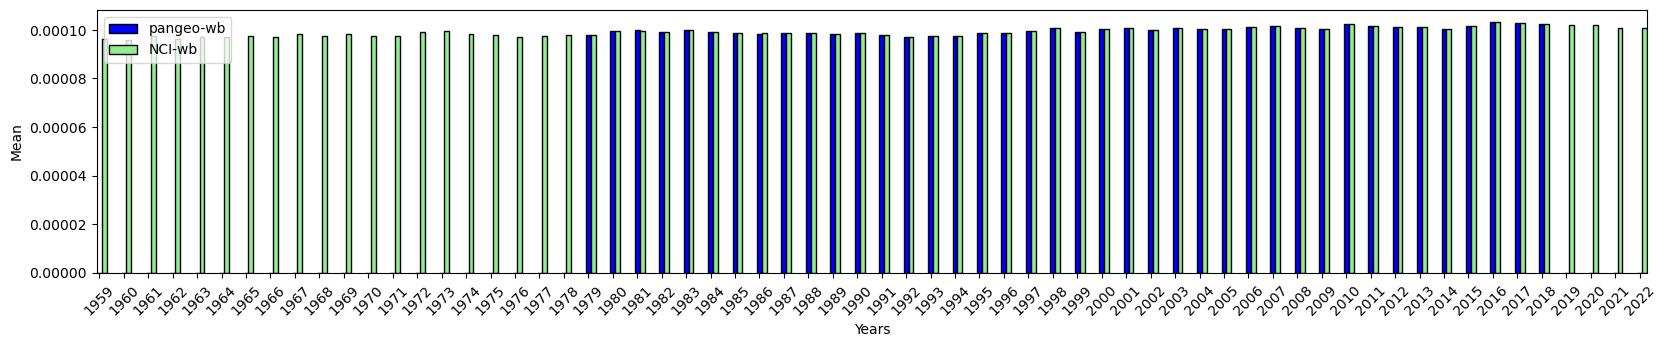

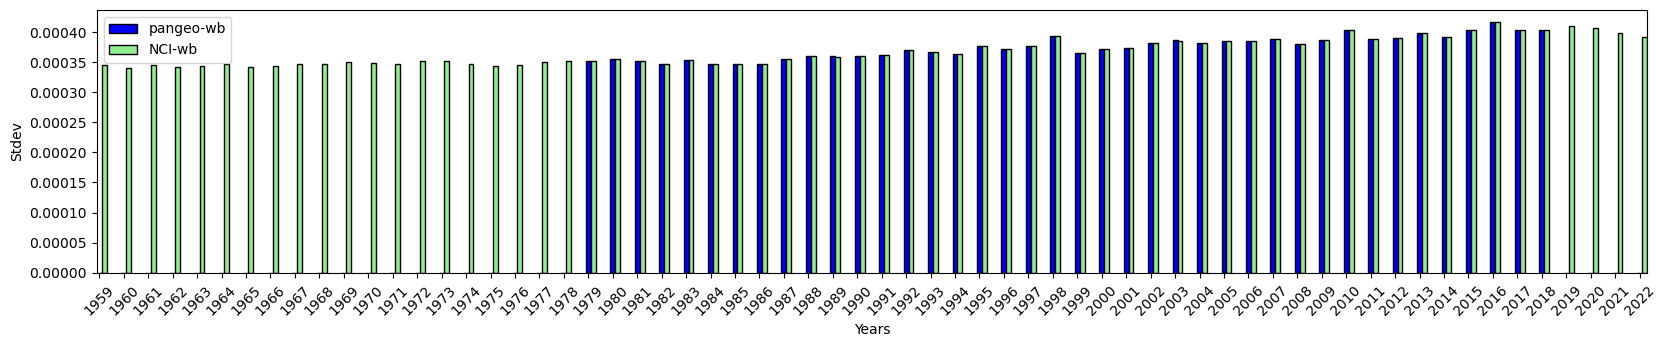

CPU times: user 1.69 s, sys: 638 ms, total: 2.33 s
Wall time: 14.1 s


In [18]:
%%time

year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'total_precipitation', 'tp') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'total_precipitation', 'tp')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")  


# u_component_of_wind

1963 (Missing), 1960 (Missing), 1967 (Missing), 1959 (Missing), 1965 (Missing), 1961 (Missing), 1968 (Missing), 1973 (Missing), 1964 (Missing), 1962 (Missing), 1966 (Missing), 1969 (Missing), 1971 (Missing), 1972 (Missing), 1975 (Missing), 1977 (Missing), 1974 (Missing), 1976 (Missing), 1970 (Missing), 1978 (Missing), 2020 (Missing), 2022 (Missing), 2021 (Missing), 2019 (Missing), 1998, 1999, 2012, 1997, 1985, 1990, 1988, 2008, 1991, 1994, 2000, 2018, 2005, 1996, 2015, 1982, 1989, 1981, 1993, 2013, 2002, 2014, 2003, 2017, 2007, 1986, 2009, 2011, 1995, 2010, 2001, 2006, 1987, 1992, 1979, 1984, 1980, 2004, 2016, 1983, 
------
2001, 2009, 1986, 1987, 1985, 1974, 2004, 2003, 1997, 2002, 1970, 1992, 1972, 1995, 1961, 1990, 1978, 1964, 1959, 1965, 1979, 2000, 1971, 1981, 1991, 1977, 1982, 1989, 1996, 1993, 2012, 1960, 1983, 1969, 2014, 2006, 1976, 2013, 1999, 2005, 1984, 2011, 1994, 2007, 1975, 1962, 1998, 2010, 1963, 1967, 1966, 1968, 1973, 2015, 2016, 2008, 2018, 1988, 1980, 2019, 2021, 20

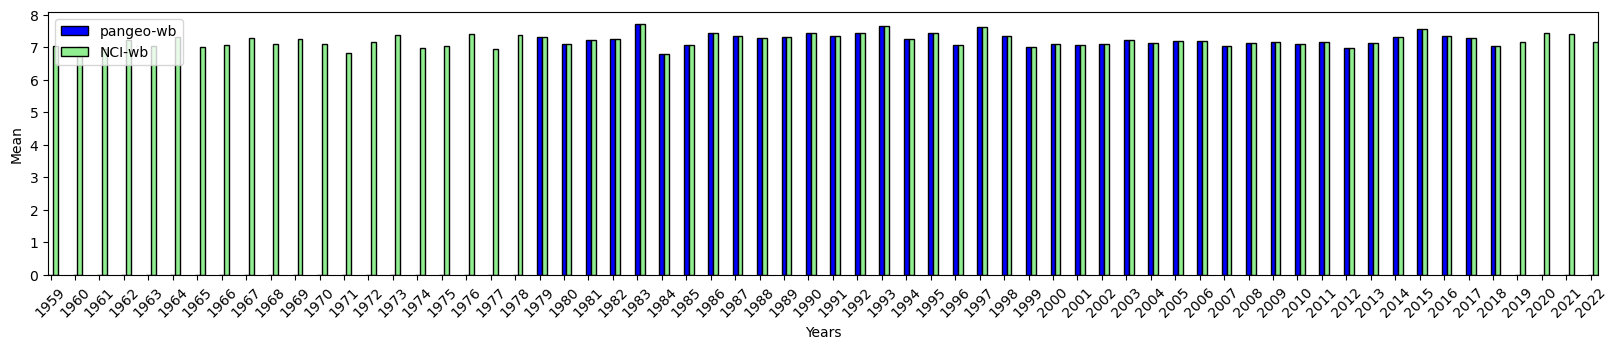

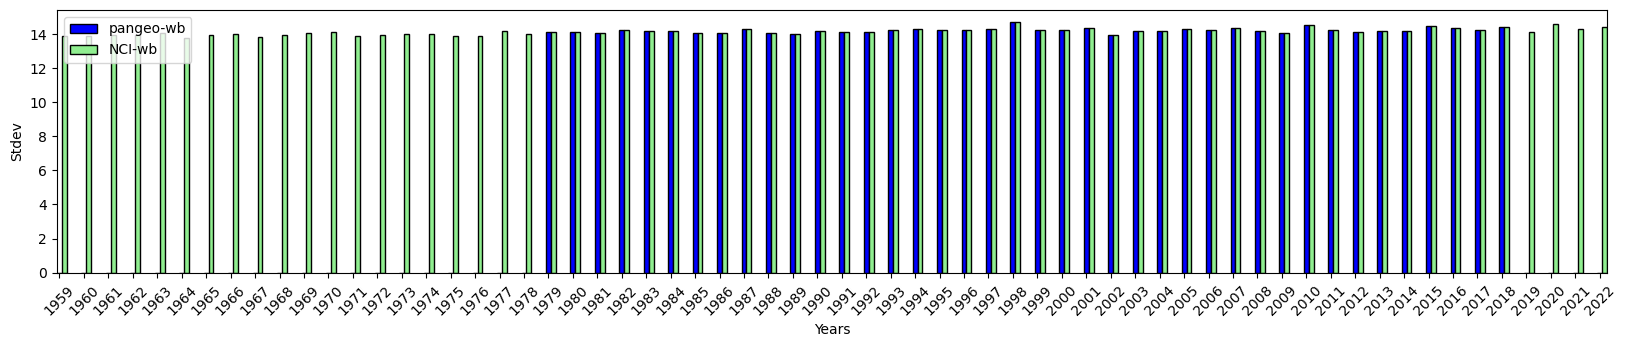

CPU times: user 1.66 s, sys: 677 ms, total: 2.33 s
Wall time: 56 s


In [19]:
%%time
year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'u_component_of_wind', 'u') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'u_component_of_wind', 'u')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")    


# v_component_of_wind

1965 (Missing), 1968 (Missing), 1960 (Missing), 1963 (Missing), 1967 (Missing), 1964 (Missing), 1959 (Missing), 1962 (Missing), 1970 (Missing), 1969 (Missing), 1966 (Missing), 1971 (Missing), 1961 (Missing), 1974 (Missing), 1975 (Missing), 1977 (Missing), 1972 (Missing), 1973 (Missing), 1976 (Missing), 1978 (Missing), 2020 (Missing), 2019 (Missing), 2021 (Missing), 2022 (Missing), 1992, 1991, 1989, 1984, 2017, 1999, 1985, 1979, 1983, 1990, 2010, 2012, 1988, 2011, 2016, 2013, 2002, 2004, 1997, 2015, 1980, 2018, 1986, 2001, 2005, 1993, 2009, 2014, 2003, 1996, 1998, 2000, 1994, 1982, 2007, 2006, 2008, 1995, 1987, 1981, 
------
2002, 2001, 1961, 1983, 1985, 1971, 1970, 2005, 1973, 1978, 1979, 1967, 1972, 1962, 2012, 1977, 1999, 1996, 1976, 1964, 2014, 2000, 1963, 1987, 2013, 1965, 1975, 2003, 1968, 1980, 1991, 1998, 1969, 1992, 1994, 1993, 1959, 2004, 1981, 1997, 1984, 2006, 1966, 2008, 2010, 1960, 1988, 1986, 2017, 1995, 1982, 2009, 2016, 2015, 2019, 2021, 2020, 2022, 2018, 2007, 1989, 19

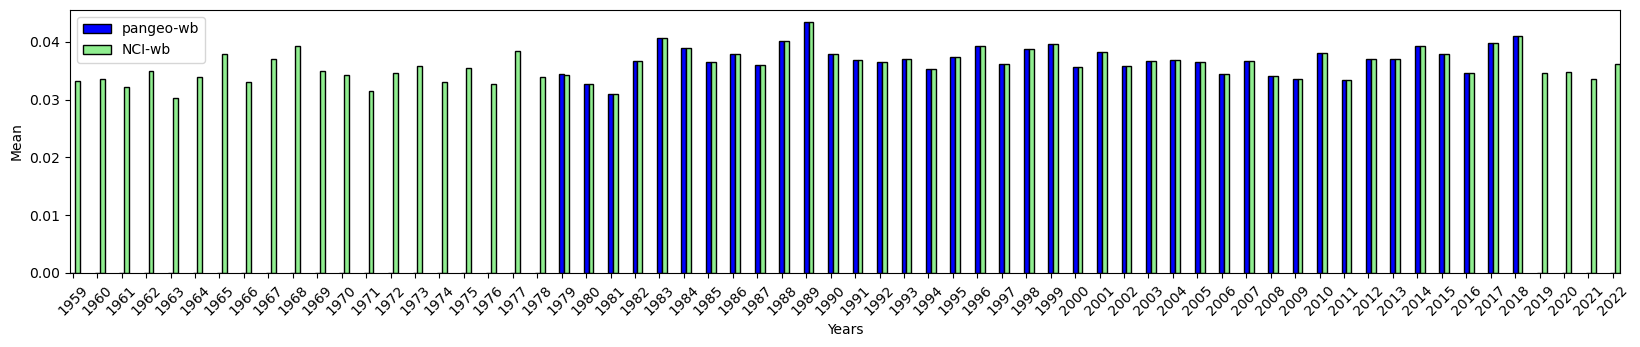

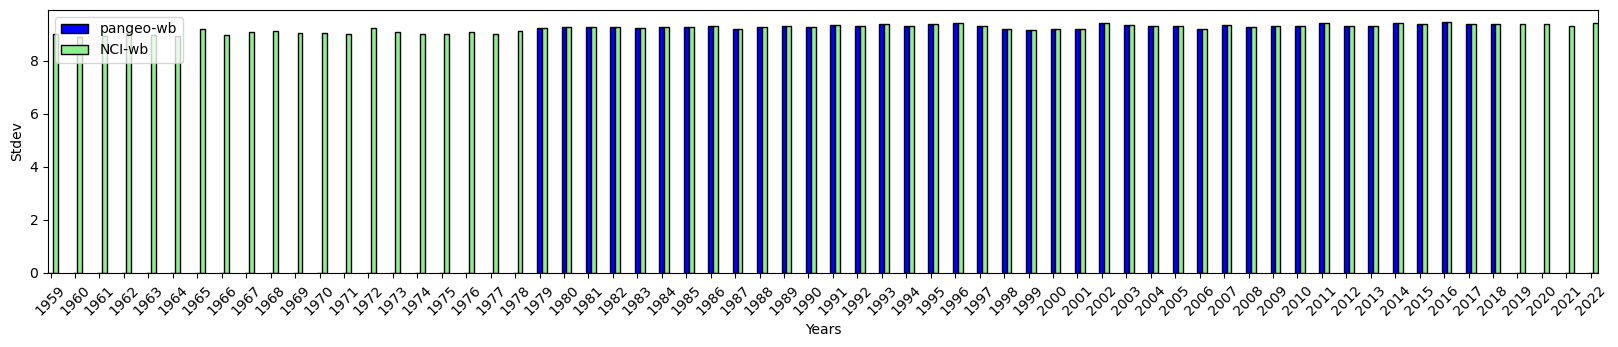

CPU times: user 1.74 s, sys: 1.8 s, total: 3.53 s
Wall time: 46.9 s


In [20]:
%%time

year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'v_component_of_wind', 'v') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'v_component_of_wind', 'v')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")    


# vorticity

1962 (Missing), 1960 (Missing), 1961 (Missing), 1959 (Missing), 1966 (Missing), 1963 (Missing), 1965 (Missing), 1970 (Missing), 1973 (Missing), 1969 (Missing), 1964 (Missing), 1971 (Missing), 1968 (Missing), 1967 (Missing), 1975 (Missing), 1972 (Missing), 1985 (Missing), 1974 (Missing), 1980 (Missing), 1978 (Missing), 1986 (Missing), 1976 (Missing), 1977 (Missing), 1987 (Missing), 1983 (Missing), 1981 (Missing), 1979 (Missing), 1988 (Missing), 1982 (Missing), 1995 (Missing), 1991 (Missing), 1996 (Missing), 1990 (Missing), 1989 (Missing), 2001 (Missing), 2006 (Missing), 2007 (Missing), 1998 (Missing), 1993 (Missing), 1992 (Missing), 2000 (Missing), 1999 (Missing), 1994 (Missing), 2004 (Missing), 2002 (Missing), 2005 (Missing), 1997 (Missing), 2016 (Missing), 2015 (Missing), 2017 (Missing), 2003 (Missing), 2012 (Missing), 2010 (Missing), 2011 (Missing), 2019 (Missing), 2008 (Missing), 2018 (Missing), 2009 (Missing), 2021 (Missing), 2014 (Missing), 2013 (Missing), 2020 (Missing), 2022 (Mi

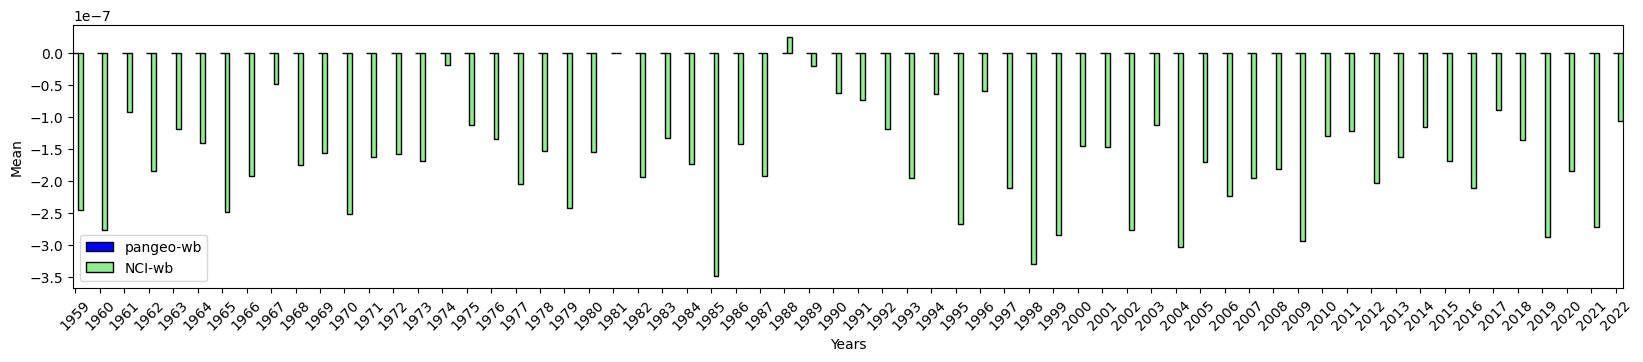

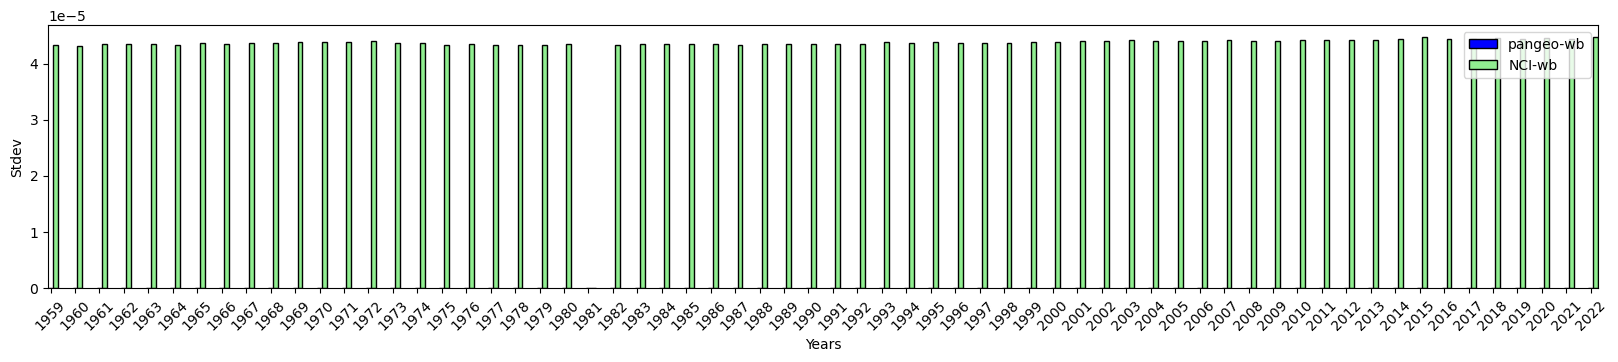

CPU times: user 1.7 s, sys: 652 ms, total: 2.35 s
Wall time: 38.9 s


In [21]:
%%time

year_vals_1,  mean_vals_1, std_vals_1  = yearly_mean_mp (wb_dir , 1959, 2022, 'vorticity', 'vo') 
print ("\n------")
year_vals_2,  mean_vals_2, std_vals_2  = yearly_mean_mp (NCI_dir, 1959, 2022, 'vorticity', 'vo')  
display_compare(year_vals_1, mean_vals_1, mean_vals_2, "Mean")  
display_compare(year_vals_1, std_vals_1,  std_vals_2,  "Stdev")  